<a href="https://colab.research.google.com/github/tcoonsUM/bayes_mfuq/blob/main/pilot_sampling_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of pilot sampling termination methods

## Response to reviewer comments for JUQ #M179016.

In [ ]:
# only run this once to install MXMCPy!!
!git clone -b develop https://github.com/nasa/MXMCPy.git
! ls
!pip install ./MXMCPy/
from mxmc import Optimizer
from mxmc import Estimator
from mxmc import OutputProcessor

fatal: destination path 'MXMCPy' already exists and is not an empty directory.
MXMCPy	sample_data
Processing ./MXMCPy
  Preparing metadata (setup.py) ... done
  Created wheel for mxmcpy: filename=mxmcpy-1.0-py3-none-any.whl size=52712 sha256=9117504945bfa73604c985c20509c82e38c722f5a9707e0e03e7eaf0171d17be
  Stored in directory: /tmp/pip-ephem-wheel-cache-ufekr9ky/wheels/31/9c/42/f14bba47ba42b1b4532c392cc9ea43a1651a8bb0066b526d63
Successfully built mxmcpy
  Attempting uninstall: mxmcpy
    Found existing installation: mxmcpy 1.0
    Uninstalling mxmcpy-1.0:
      Successfully uninstalled mxmcpy-1.0


In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import seaborn as sns

# Set style and seed
sns.set_theme(style="whitegrid")
np.random.seed(42)

print("Libraries loaded.")

Libraries loaded.


## Problem Setup: 1D Heat Diffusion

We are modeling the steady-state temperature $T(x)$ in a rod of length $L=1$, subject to a heat source $s(x)$. The governing equation is:

$$ - \frac{d}{dx} \left( \kappa(x; \mathbf{Z}) \frac{dT}{dx} \right) = s(x) $$

where the source term $s(x)=50$ is a constant heat source and the thermal conductivity is sinusoidally varying across the length of the rod, given by:
$$ \kappa(x, \mathbf{Z}) = \mathbf{Z_0} + \mathbf{Z_1} \sin(2\pi x) + 0.5x$$


---


**Uncertain Parameters:**

The thermal conductivity $\kappa(x, \mathbf{Z})$ is uncertain, parameterized by random vector $\mathbf{Z}=[\mathbf{Z_0}, \mathbf{Z_1}]^\top$.

* $\mathbf{Z_0}\sim U(0.8, 2)$: Base conductivity
* $\mathbf{Z_1}\sim U(0, 0.5)$: Amplitude of sinusoidal variation

---


**UQ Analysis:**

We define the quantity of interest as the mean temperature across the rod, defined $\bar{T}(Z)$ for a particular set of parameter values $Z$. The UQ goal is then to estimate the QOI mean $\mathbb{E}_\mathbf{Z}[\bar{T}(z)] $, over the uncertainty encoded in $\mathbf{Z}$.

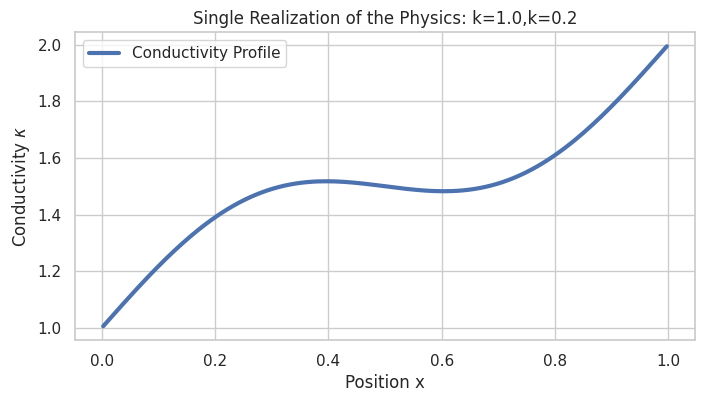

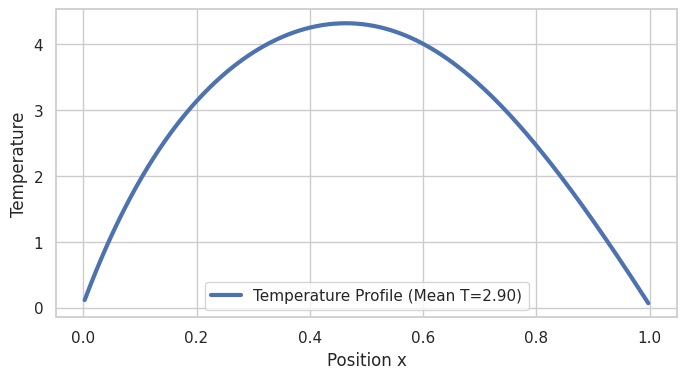

In [ ]:
# define heat equation problem
L = 1.0
Source_Mag = 50.0

def get_conductivity(x, Z):
    """
    Random conductivity field parameterized by Z.
    Z[0]: Base conductivity
    Z[1]: Amplitude of variation
    """
    # k(x) = Z0 + Z1 * sin(2*pi*x) + linear_drift
    k = Z[0] + Z[1] * np.sin(2 * np.pi * x) + x
    return np.clip(k, 0.1, None) # Ensure physical positivity (k > 0)

def run_fem_solver(Z, n_elements):
    """
    1D Finite Difference Solver for -d/dx(k dT/dx) = s
    Returns:
        QoI: Average Temperature in the rod
        T: The full temperature field
        x: The grid points
    """
    dx = L / n_elements
    x = np.linspace(dx/2, L-dx/2, n_elements) # Cell centers

    # Evaluate random conductivity at cell faces
    x_faces = np.linspace(0, L, n_elements + 1)
    k_faces = get_conductivity(x_faces, Z)

    # Assembly (Standard Tridiagonal Heat Matrix)
    k_left = k_faces[:-1] / dx**2
    k_right = k_faces[1:] / dx**2

    diagonals = [
        -k_left[1:],           # Lower diag
        k_left + k_right,      # Main diag
        -k_right[:-1]          # Upper diag
    ]

    A = diags(diagonals, [-1, 0, 1], shape=(n_elements, n_elements), format='csc')
    b = np.full(n_elements, Source_Mag)

    # Solve system
    T = spsolve(A, b)

    # Quantity of Interest: Mean Temperature in the rod
    QoI = np.mean(T)
    return QoI, T, x

# visualizing an example realization of Z
Z_example = [1.0, 0.2] # Mean k=1, variability=0.2
Q, T_field, x_grid = run_fem_solver(Z_example, n_elements=200)

k_test = get_conductivity(x_grid, Z_example)
plt.figure(figsize=(8, 4))
plt.plot(x_grid, k_test, lw=3, label='Conductivity Profile')
plt.title(f"Single Realization of the Physics: k={Z_example[0]:.1f},k={Z_example[1]:.1f}")
plt.ylabel(r"Conductivity $\kappa$")
plt.xlabel("Position x")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(x_grid, T_field, lw=3, label=f'Temperature Profile (Mean T={Q:.2f})')
plt.ylabel("Temperature")
plt.xlabel("Position x")
plt.legend()
plt.show()

## Multi-fidelity Ensemble

We create three models, in order of cost and correlation:


1.   $f_0$: The high-fidelity solver, with 200 finite elements to resolve the underlying physics.
2.   $f_1$: A low-fidelity finite-element model with just 20 elements.
3.   $f_2$: A low-fidelity finite-element model with just 6 elements.
4.   $f_3$: A low-fidelity simplified physics model that ignores the variation in $\kappa$ across the rod, enabling an analytical result.

The model costs are $w = [1, 0.1, 0.005, 0.003]^T$ and we have a total budget for MFMC of $50$.



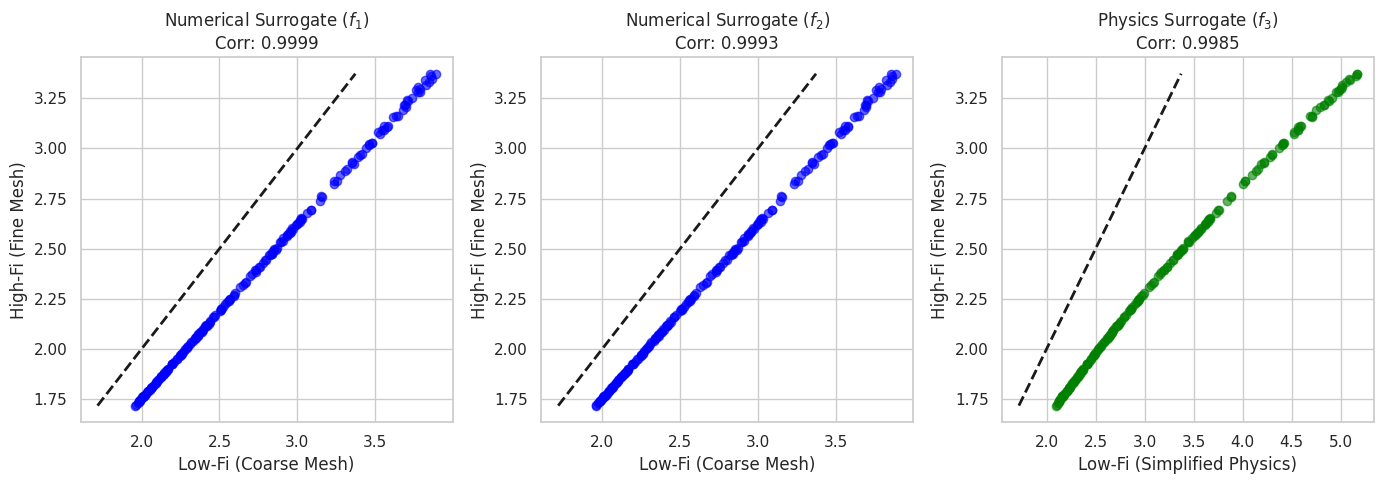

In [ ]:
def model_high_fidelity(Z):
    """f0: Expensive, fine mesh physics"""
    q, _, _ = run_fem_solver(Z, n_elements=200)
    return q

def model_low_fi_numerical2(Z):
    """f1: Cheap, coarse mesh physics"""
    q, _, _ = run_fem_solver(Z, n_elements=20)
    return q

def model_low_fi_numerical(Z):
    """f2: Cheap, coarse mesh physics"""
    q, _, _ = run_fem_solver(Z, n_elements=6)
    return q

def model_low_fi_physics(Z):
    """f3: Analytical Approx
    Assumes k is constant (using the average of the random inputs).
    Analytical solution for -k T'' = s with T(0)=T(L)=0 is a parabola.
    """
    k_eff = Z[0] # Ignore spatial variation Z[1]
    # Analytical average temp for constant k
    q = (Source_Mag * L**2) / (12 * k_eff)
    return q

# Generate synthetic input data (Z ~ Uniform)
N_test = 200
Z_samples = np.random.uniform(low=[0.8, 0.0], high=[2.0, 0.5], size=(N_test, 2))

# Evaluate all models
y0 = np.array([model_high_fidelity(z) for z in Z_samples])
y1 = np.array([model_low_fi_numerical2(z) for z in Z_samples])
y2 = np.array([model_low_fi_numerical(z) for z in Z_samples])
y3 = np.array([model_low_fi_physics(z) for z in Z_samples])

# Visualize Correlations
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Plot f0 vs f1 (Numerical Surrogate)
corr1 = np.corrcoef(y0, y1)[0,1]
ax[0].scatter(y1, y0, alpha=0.6, c='blue')
ax[0].plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=2) # 1:1 line
ax[0].set_title(f"Numerical Surrogate ($f_1$)\nCorr: {corr1:.4f}")
ax[0].set_xlabel("Low-Fi (Coarse Mesh)")
ax[0].set_ylabel("High-Fi (Fine Mesh)")

# Plot f0 vs f2 (Numerical Surrogate)
corr1 = np.corrcoef(y0, y2)[0,1]
ax[1].scatter(y1, y0, alpha=0.6, c='blue')
ax[1].plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=2) # 1:1 line
ax[1].set_title(f"Numerical Surrogate ($f_2$)\nCorr: {corr1:.4f}")
ax[1].set_xlabel("Low-Fi (Coarse Mesh)")
ax[1].set_ylabel("High-Fi (Fine Mesh)")

# Plot f0 vs f2 (Physics Surrogate)
corr2 = np.corrcoef(y0, y3)[0,1]
ax[2].scatter(y3, y0, alpha=0.6, c='green')
ax[2].plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=2)
ax[2].set_title(f"Physics Surrogate ($f_3$)\nCorr: {corr2:.4f}")
ax[2].set_xlabel("Low-Fi (Simplified Physics)")
ax[2].set_ylabel("High-Fi (Fine Mesh)")

plt.tight_layout()
plt.show()

# Take-away Number One:
## The oracle sample allocation does not permit many shared samples.

Taking 5000 samples to estimate the oracle covariances, we see that the oracle sample allocation only has 7 high-fidelity samples. These 7 shared samples are the target for online pilot and pilot projection.

In [ ]:
# oracle pilot sampling with 5K samples
M=4
N_test = 5000
np.random.seed(42)
Z_1 = np.random.uniform(low=[0.8, 0.0], high=[2.0, 0.5], size=(int(N_test), 2))
y_0 = np.array([model_high_fidelity(z) for z in Z_1])
y_1 = np.array([model_low_fi_numerical2(z) for z in Z_1])
y_2 = np.array([model_low_fi_numerical(z) for z in Z_1])
y_3 = np.array([model_low_fi_physics(z) for z in Z_1])

# compute covariance matrix
all_y = np.stack((y_0, y_1, y_2,y_3))
all_y.shape
cov_matrix = np.cov(all_y)
corr_matrix = np.corrcoef(all_y)
print(f'Covariance Matrix:\n{cov_matrix}\n')
print(f'Correlation Matrix:\n{corr_matrix}\n')

Covariance Matrix:
[[0.21780232 0.2518234  0.35026141 0.39606527]
 [0.2518234  0.29119685 0.40513793 0.45799097]
 [0.35026141 0.40513793 0.56399048 0.63717249]
 [0.39606527 0.45799097 0.63717249 0.72250714]]

Correlation Matrix:
[[1.         0.99993435 0.99936735 0.99842267]
 [0.99993435 1.         0.99970917 0.99848722]
 [0.99936735 0.99970917 1.         0.99815975]
 [0.99842267 0.99848722 0.99815975 1.        ]]



mfmc method variance: [2.79216583e-05]
Best method: mfmc
True alpha: [-0.86478749 -0.62104135 -0.5481818 ]


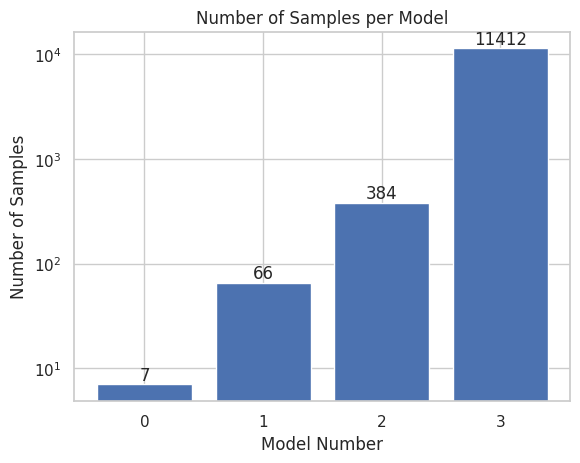

In [ ]:
# perform MXMCPy optimization loop
M=4
c_total = 50
c_vec = np.array([1, 20/200, 1/200, 3/1000])
variance_results = dict()
sample_allocation_results = dict()
mxmc_optimizer = Optimizer(c_vec, np.transpose(cov_matrix))
algorithms = Optimizer.get_algorithm_names()
for algorithm in ['mfmc']:#algorithms:
    opt_result = mxmc_optimizer.optimize(algorithm, c_total)
    variance_results[algorithm] = opt_result.variance
    sample_allocation_results[algorithm] = opt_result.allocation
    print("{} method variance: {}".format(algorithm, opt_result.variance))
best_method = min(variance_results, key=variance_results.get)
print("Best method: " + best_method)
sample_allocation = sample_allocation_results[best_method]
best_case_var = variance_results[best_method]

plt.figure()
plt.bar(["0","1","2","3"],sample_allocation.get_number_of_samples_per_model())
for i, v in enumerate(sample_allocation.get_number_of_samples_per_model()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.yscale('log')
plt.xlabel("Model Number")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Model")

estimator = Estimator(sample_allocation, cov_matrix)
true_alpha = estimator._alpha
print(f'True alpha: {true_alpha}')

# Take-away Number Two:
## The optimal number of pilot samples to take is in the 15-20 range, and the oracle sample allocation of 7 shared samples is therefore not the optimal target.

Below, we iterate over different sizes of pilot samples, which are in turn used to compute sample covariance matrices and set MFMC weights and sample allocations. At each sample size, we run 50 pilot sampling trials and compute the corresponding true estimator variances. The true estimator variances are plotted at the end, showing that the best estimator performances, on average, are actually when 15-20 pilot samples are drawn.

We use a constrained MFMC code to solve the constrained sample allocation problem such that pilot samples can be reused.

Optimal n_mfmc (Unconstrained): [    7    66   384 11412]


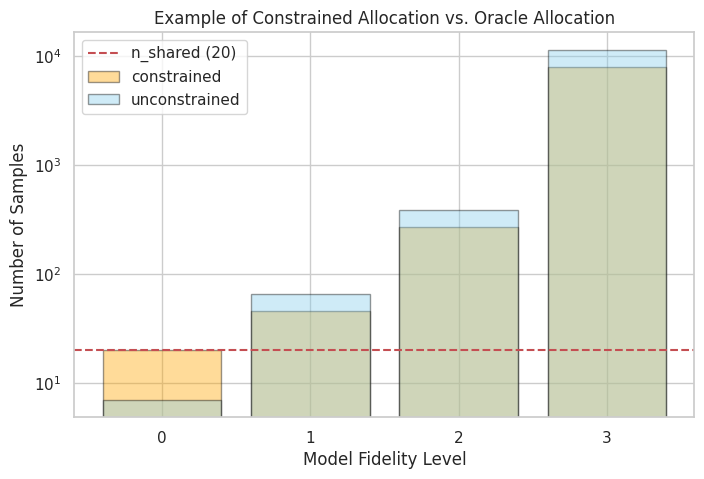

Optimal n_mfmc (Constrained): [  20   46  269 7994]
Used Cost: 49.93 / 50


In [ ]:
# redoing MFMC sample allocation analytically
n_shared = 20
alpha_mfmc = np.zeros((M,))
r_mfmc = np.zeros((M,))
corr_matrix_mfmc = np.pad(corr_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)

for m in range(M):
    alpha_mfmc[m] = corr_matrix_mfmc[0, m] * np.sqrt(cov_matrix[0,0]) / np.sqrt(cov_matrix[m, m])
    num = c_vec[0] * (corr_matrix_mfmc[0, m]**2 - corr_matrix_mfmc[0, m+1]**2)
    den = c_vec[m] * (1 - corr_matrix_mfmc[0, 1]**2)
    r_mfmc[m] = np.sqrt(num / den)

n0 = c_total / (c_vec @ r_mfmc)
n_mfmc_opt = np.floor(n0 * r_mfmc).astype(int)
print(f"Optimal n_mfmc (Unconstrained): {n_mfmc_opt}")

def calculate_total_cost(n0_scalar):
    """
    Calculates total cost if we set high-fidelity samples to n0_scalar
    and scale everyone else by optimal ratios r_mfmc, subject to n_shared.
    """
    n_proposed = n0_scalar * r_mfmc

    # 2. Apply n_shared floor
    n_constrained = np.maximum(n_shared, n_proposed)

    # 3. Compute cost
    cost = np.dot(n_constrained, c_vec)
    return cost

def get_constrained_allocation(cov_in, cost_vec, budget, min_samples):
    """
    Computes sample allocation preserving optimal ratios subject to n_shared.
    """
    M_models = cov_in.shape[0]

    # Convert cov to corr
    d_in = np.sqrt(np.diag(cov_in))
    corr_in = cov_in / np.outer(d_in, d_in)

    # Pad correlation for the loop (index m+1)
    corr_pad = np.pad(corr_in, ((0, 1), (0, 1)), mode='constant', constant_values=0)

    r_vec = np.zeros(M_models)
    alpha_vec = np.zeros(M_models) # Helper to return alphas too, as they depend on cov_in

    for m in range(M_models):
        # Calculate Alpha
        alpha_vec[m] = corr_pad[0, m] * np.sqrt(cov_in[0,0]) / np.sqrt(cov_in[m, m])

        # Calculate Ratio
        num = cost_vec[0] * (corr_pad[0, m]**2 - corr_pad[0, m+1]**2)
        den = cost_vec[m] * (1 - corr_pad[0, 1]**2)

        # Safety for negative numbers inside sqrt due to noise
        if num < 0 or den < 0:
             r_vec[m] = 0 # Fallback: if correlation is broken, don't allocate
        else:
             r_vec[m] = np.sqrt(num / den)

    # Binary Search for Scaling Factor N0
    low = 0.0
    high = budget / cost_vec[0]
    optimal_n0 = 0.0

    # Check minimum feasibility
    min_cost = np.dot(np.full(M_models, min_samples), cost_vec)
    if min_cost > budget:
        # Budget too tight, return floor
        return np.full(M_models, min_samples, dtype=int), alpha_vec

    for _ in range(30):
        mid = (low + high) / 2.0
        # Proposed N
        n_prop = mid * r_vec
        # Apply Constraint
        n_cons = np.maximum(min_samples, n_prop)
        cost = np.dot(n_cons, cost_vec)

        if cost <= budget:
            optimal_n0 = mid
            low = mid
        else:
            high = mid

    n_final = np.floor(optimal_n0 * r_vec).astype(int)
    n_final = np.maximum(min_samples, n_final)

    return n_final, alpha_vec


n_mfmc, alphas_test = get_constrained_allocation(cov_matrix, c_vec, c_total, n_shared)

plt.figure(figsize=(8, 5))
labels = [str(i) for i in range(M)]
plt.bar(labels, n_mfmc, color='orange', alpha=0.4,edgecolor='black',label='constrained')
plt.bar(labels, n_mfmc_opt, color='skyblue', alpha=0.4,edgecolor='black', label='unconstrained')
plt.axhline(n_shared, color='r', linestyle='--', label=f'n_shared ({n_shared})')
plt.yscale('log')
plt.xlabel("Model Fidelity Level")
plt.ylabel("Number of Samples")
plt.title(f"Example of Constrained Allocation vs. Oracle Allocation")
plt.legend()
plt.show()

print(f"Optimal n_mfmc (Constrained): {n_mfmc}")
print(f"Used Cost: {np.sum(n_mfmc * c_vec):.2f} / {c_total}")

In [ ]:
def calculate_true_variance_from_vecs(n_vec, alphas, true_cov_mat):
    """
    Computes theoretical variance using n_vec and alphas against the TRUE covariance.
    Eq: Var(est) = Var(Y0)/N0 + Sum [ (1/N_{m-1} - 1/N_m) * Var(alpha*Y_m - Y_0) ]
    """
    var_0 = true_cov_mat[0, 0] / n_vec[0]
    mfmc_var = var_0
    M = len(n_vec)

    # Coeffs for the delta terms: (1/N_{m-1} - 1/N_m)
    coeffs = np.zeros(M-1)
    for i in range(M-1):
        m = i + 1
        coeffs[i] = (1.0 / n_vec[m-1]) - (1.0 / n_vec[m])

    term_quadratic = 0
    term_linear = 0

    active_alphas = alphas[1:]

    for i in range(M-1):
        m = i + 1
        # cov_delta_delta
        c_dd = coeffs[i] * true_cov_mat[m, m]
        term_quadratic += active_alphas[i] * c_dd * active_alphas[i]

        # cov_q_delta
        c_qd = coeffs[i] * true_cov_mat[0, m]
        term_linear += active_alphas[i] * c_qd

    true_var = var_0 + term_quadratic - 2 * term_linear

    return true_var

# sweeping over different pilot sample sizes

pilot_vals = np.arange(5,37,2)  # Iterate pilot sizes
n_trials = 50
results_matrix = np.zeros((len(pilot_vals), n_trials))

for i, p_size in enumerate(pilot_vals):
    n_shared = p_size  # Constraint: n_shared grows with pilot size
    trial_num = 0

    for trial in range(n_trials):
        trial_num = trial_num + 1

        np.random.seed(trial_num)
        Z_0 = np.random.uniform(low=[0.8, 0.0], high=[2.0, 0.5], size=(int(p_size), 2))
        y_0 = np.array([model_high_fidelity(z) for z in Z_0])
        y_1 = np.array([model_low_fi_numerical2(z) for z in Z_0])
        y_2 = np.array([model_low_fi_numerical(z) for z in Z_0])
        y_3 = np.array([model_low_fi_physics(z) for z in Z_0])

        pilot_y = np.stack((y_0, y_1, y_2, y_3))
        cov_noisy = np.cov(pilot_y)

        n_alloc, alpha_full = get_constrained_allocation(cov_noisy, c_vec, c_total, n_shared)

        true_var = calculate_true_variance_from_vecs(n_alloc, alpha_full, cov_matrix)

        results_matrix[i, trial] = true_var

# Getting statistics/results
mean_vars = np.mean(results_matrix, axis=1)
q20_vars = np.percentile(results_matrix, 10, axis=1)
q80_vars = np.percentile(results_matrix, 90, axis=1)


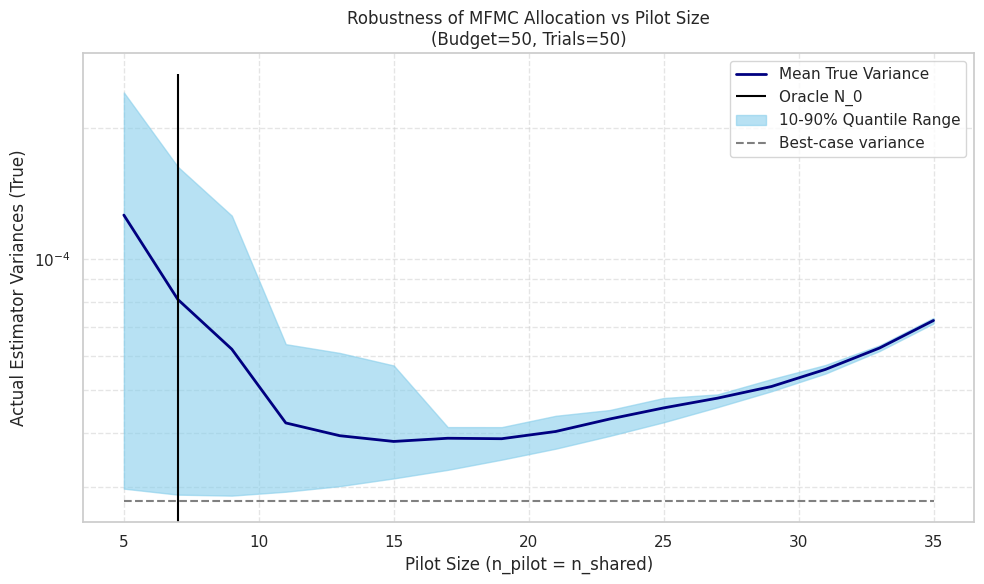

In [ ]:
plt.figure(figsize=(10, 6))

# Mean results
plt.plot(pilot_vals, mean_vars, label='Mean True Variance', color='navy', linewidth=2)

# 20/80 Quantile shading
adapt_mvn_mean = 18.2

plt.vlines(7.,0,1.1*q80_vars.max(),colors='black',label='Oracle N_0')
plt.fill_between(pilot_vals, q20_vars, q80_vars,
                 color='skyblue', alpha=0.6,
                 label='10-90% Quantile Range')

plt.hlines(best_case_var, pilot_vals.min(), pilot_vals.max(), linestyles='dashed',colors='gray',label='Best-case variance')

plt.xlabel('Pilot Size (n_pilot = n_shared)')
plt.ylabel('Actual Estimator Variances (True)')
plt.title(f'Robustness of MFMC Allocation vs Pilot Size\n(Budget={c_total}, Trials={n_trials})')
plt.yscale('log') # Log scale is recommended for variance plots
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Take-away Number Three:
## Our method terminates closer to the optimal range than pilot projection or online pilot.

Offline, we ran our Bayesian termination algorithm with an uninformative GG-MVN prior and a step size of 2 pilot samples for 20 trials, producing termination between 14-22 over those trials. In addition, we run the online pilot and pilot projection methods for 50 trials with an initial batch of 5 pilot samples and find that they terminate between 5-9 and 5-8 pilot samples, respectively. This highlights the susceptibility to early termination of these methods since they do not account for covariance uncertainty.

In [ ]:
# pilot projection and online pilot code
def calculate_cov_delta_terms(estimator, true_cov):
        k_0 = estimator._allocation.get_k0_matrix()
        k = estimator._allocation.get_k_matrix()
        cov_q_delta = k_0 * true_cov[0, 1:]
        cov_delta_delta = k * true_cov[1:, 1:]
        return cov_delta_delta, cov_q_delta

def calculate_true_variance(cov_delta_delta, cov_q_delta, alpha, true_cov, sample_allocation):
        var_sf = true_cov[0, 0] / sample_allocation.get_number_of_samples_per_model()[0]
        true_var = var_sf + alpha @ cov_delta_delta @ alpha + 2 * alpha @ cov_q_delta
        return true_var

pilot_size = 5
n_trials = 50

# online pilot
pilot_sizes_op = np.zeros((n_trials,))
alphas_op = np.zeros((n_trials,M-1))
delta_ns_op = np.zeros((n_trials,))
proj_vars_op = np.zeros((n_trials,))
true_vars_op = np.zeros((n_trials,))

# pilot projection
pilot_sizes_pp = np.zeros((n_trials,))
proj_vars_pp = np.zeros((n_trials,))
true_vars_pp = np.zeros((n_trials,))
alphas_pp = np.zeros((n_trials,M-1))
delta_ns_pp = np.zeros((n_trials,))

trial_num = 0
for trial in range(n_trials):
  trial_num +=1

  np.random.seed(trial_num)
  Z_0 = np.random.uniform(low=[0.8, 0.0], high=[2.0, 0.5], size=(int(pilot_size), 2))
  y_0 = np.array([model_high_fidelity(z) for z in Z_0])
  y_1 = np.array([model_low_fi_numerical2(z) for z in Z_0])
  y_2 = np.array([model_low_fi_numerical(z) for z in Z_0])
  y_3 = np.array([model_low_fi_physics(z) for z in Z_0])
  pilot_y = np.stack((y_0, y_1, y_2,y_3))
  cov_noisy = np.cov(pilot_y)
  corr_noisy = np.corrcoef(pilot_y)

  variance_results = dict()
  sample_allocation_results = dict()
  mxmc_optimizer = Optimizer(c_vec, cov_noisy)
  algorithms = Optimizer.get_algorithm_names()
  for algorithm in ['mfmc']:
      opt_result = mxmc_optimizer.optimize(algorithm, c_total)
      variance_results[algorithm] = opt_result.variance
      sample_allocation_results[algorithm] = opt_result.allocation
  best_method = min(variance_results, key=variance_results.get)
  sample_allocation = sample_allocation_results[best_method]
  estimator = Estimator(sample_allocation, cov_noisy)

  cov_delta_delta, cov_q_delta = calculate_cov_delta_terms(estimator, cov_matrix)

  # BEGINNING PILOT PROJECTION
  # pilot projection mode does not re-check after one iteration, so delta_ns are final
  delta_ns_pp[trial] = sample_allocation.get_number_of_samples_per_model()[0]-pilot_size

  # terminate if
  if delta_ns_pp[trial]<0:
    pilot_sizes_pp[trial] = pilot_size
  # take additional pilot samples per delta_ns[trial]
  else:

    new_pilot_size = pilot_size + delta_ns_pp[trial]
    pilot_sizes_pp[trial] = new_pilot_size
    np.random.seed(trial)
    Z_0 = np.random.uniform(low=[0.8, 0.0], high=[2.0, 0.5], size=(int(new_pilot_size), 2))
    y_0 = np.array([model_high_fidelity(z) for z in Z_0])
    y_1 = np.array([model_low_fi_numerical2(z) for z in Z_0])
    y_2 = np.array([model_low_fi_numerical(z) for z in Z_0])
    y_3 = np.array([model_low_fi_physics(z) for z in Z_0])
    pilot_y = np.stack((y_0, y_1, y_2,y_3))
    cov_noisy = np.cov(pilot_y)
    variance_results = dict()
    sample_allocation_results = dict()
    mxmc_optimizer = Optimizer(c_vec, np.transpose(cov_noisy))
    algorithms = Optimizer.get_algorithm_names()
    for algorithm in ['mfmc']:
        opt_result = mxmc_optimizer.optimize(algorithm, c_total)
        variance_results[algorithm] = opt_result.variance
        sample_allocation_results[algorithm] = opt_result.allocation
    best_method = min(variance_results, key=variance_results.get)
    sample_allocation = sample_allocation_results[best_method]
    estimator = Estimator(sample_allocation, cov_noisy)
    cov_delta_delta, cov_q_delta = calculate_cov_delta_terms(estimator, cov_matrix)

  # save pilot projection results
  alphas_pp[trial,:] = estimator._alpha
  true_vars_pp[trial] = calculate_true_variance(cov_delta_delta, cov_q_delta, estimator._alpha, cov_matrix, sample_allocation)
  proj_vars_pp[trial] = estimator.approximate_variance

  # BEGINNING ONLINE PILOT
  first_run = True # bool to check to use delta_ns_op or delta_ns_pp (use delta_ns_pp for first run only)
  if delta_ns_pp[trial]<0:
    pilot_sizes_op[trial] = pilot_size
  else:
    while delta_ns_op[trial] > 0 or first_run==True:
      if first_run:
        delta_n = delta_ns_pp[trial]
        new_pilot_size = pilot_size + delta_n
      else:
        delta_n = delta_ns_op[trial]
        new_pilot_size = new_pilot_size + delta_n
      first_run=False
      pilot_sizes_op[trial] = new_pilot_size

      np.random.seed(trial)
      Z_0 = np.random.uniform(low=[0.8, 0.0], high=[2.0, 0.5], size=(int(new_pilot_size), 2))
      y_0 = np.array([model_high_fidelity(z) for z in Z_0])
      y_1 = np.array([model_low_fi_numerical2(z) for z in Z_0])
      y_2 = np.array([model_low_fi_numerical(z) for z in Z_0])
      y_3 = np.array([model_low_fi_physics(z) for z in Z_0])
      pilot_y = np.stack((y_0, y_1, y_2,y_3))
      cov_noisy = np.cov(pilot_y)
      variance_results = dict()
      sample_allocation_results = dict()
      mxmc_optimizer = Optimizer(c_vec, np.transpose(cov_noisy))
      algorithms = Optimizer.get_algorithm_names()
      for algorithm in ['mfmc']:
          opt_result = mxmc_optimizer.optimize(algorithm, c_total)
          variance_results[algorithm] = opt_result.variance
          sample_allocation_results[algorithm] = opt_result.allocation
      best_method = min(variance_results, key=variance_results.get)
      sample_allocation = sample_allocation_results[best_method]
      estimator = Estimator(sample_allocation, cov_noisy)
      cov_delta_delta, cov_q_delta = calculate_cov_delta_terms(estimator, cov_matrix)
      delta_ns_op[trial] = sample_allocation.get_number_of_samples_per_model()[0]-new_pilot_size

  # save online pilot results (will be overwritten if delta_ns_op is still >0)
  alphas_op[trial,:] = estimator._alpha
  true_vars_op[trial] = calculate_true_variance(cov_delta_delta, cov_q_delta, estimator._alpha, cov_matrix, sample_allocation)
  proj_vars_op[trial] = estimator.approximate_variance


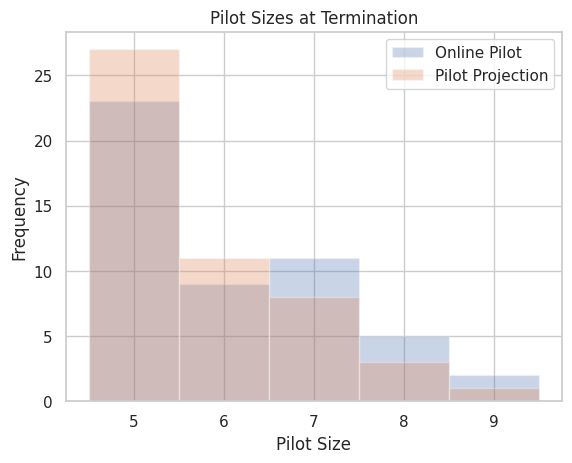

In [ ]:
min_all = int(np.min(np.concatenate((pilot_sizes_pp,pilot_sizes_op))))
max_all = int(np.max(np.concatenate((pilot_sizes_pp,pilot_sizes_op))))
bins = np.arange(min_all, max_all + 2) - 0.5

plt.figure()
plt.hist(pilot_sizes_op, bins=bins, alpha=0.3,label='Online Pilot')
plt.hist(pilot_sizes_pp, bins=bins, alpha=0.3, label='Pilot Projection')
plt.xlabel('Pilot Size')
plt.ylabel('Frequency')
plt.title('Pilot Sizes at Termination')
plt.xticks(range(min_all, max_all + 1))
plt.legend()
plt.show()



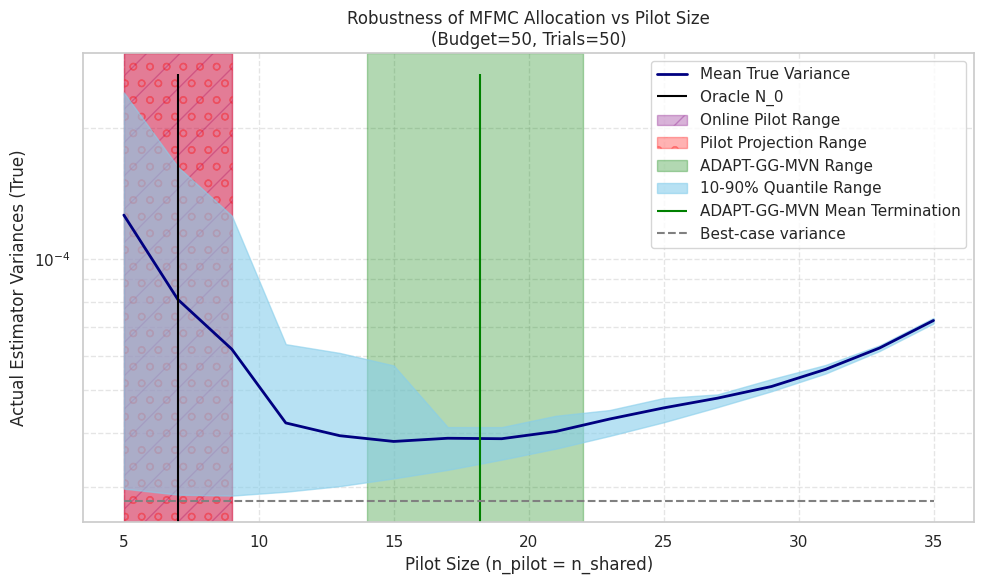

In [ ]:
plt.figure(figsize=(10, 6))

# Mean results
plt.plot(pilot_vals, mean_vars, label='Mean True Variance', color='navy', linewidth=2)

# 20/80 Quantile shading
adapt_mvn_mean = 18.2

plt.vlines(7.,0,1.1*q80_vars.max(),colors='black',label='Oracle N_0')
plt.axvspan(min(pilot_sizes_op), max(pilot_sizes_op), alpha=0.3, color='purple', hatch='/', label='Online Pilot Range')
plt.axvspan(min(pilot_sizes_pp), max(pilot_sizes_pp), alpha=0.3, color='red', hatch='o', label='Pilot Projection Range')
plt.axvspan(14, 22, alpha=0.3, color='green', label='ADAPT-GG-MVN Range')
plt.fill_between(pilot_vals, q20_vars, q80_vars,
                 color='skyblue', alpha=0.6,
                 label='10-90% Quantile Range')
plt.vlines(adapt_mvn_mean, 0, 1.1*q80_vars.max(),colors='green',label='ADAPT-GG-MVN Mean Termination')
plt.hlines(best_case_var, pilot_vals.min(), pilot_vals.max(), linestyles='dashed',colors='gray',label='Best-case variance')

plt.xlabel('Pilot Size (n_pilot = n_shared)')
plt.ylabel('Actual Estimator Variances (True)')
plt.title(f'Robustness of MFMC Allocation vs Pilot Size\n(Budget={c_total}, Trials={n_trials})')
plt.yscale('log') # Log scale is recommended for variance plots
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()